<a href="https://colab.research.google.com/github/Graviton12/CS-430-Group-Project/blob/main/cherokee_park_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applying Models to Cherokee Park 2024 and 2021 Datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# imports for models
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# **Model 1: K-Means Clustering**

## K-Means Clustering Model to cluster data for Cherokee 2024 + 2021 data

In [3]:
# imports for k means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
data = pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="Olmstead_combined")

In [5]:
data.head()

,trimble station,average_canopy_cover,canopy,understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,Cherokee1,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,Cherokee2,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,Cherokee3,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,Cherokee4,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,Cherokee5,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
#drop last column
data = data.iloc[:, :-1]
#drop understory
data = data.drop(columns=['understory'])
#drop trimble station
data = data.drop(columns=['trimble station'])

In [7]:
data.head()

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum
0,92.98,"Walnut, maple, mulberry, locust",1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0
1,98.18,"Cherry, hackberry, maple",4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0
2,97.40,"Oak, basswood, maple",3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0
3,93.24,"Locust, walnut, sycamore",1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0
4,87.00,"Oak, maple, locust",0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
numeric_data = data.select_dtypes(include=np.number)

# Create and apply the imputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(numeric_data)


# Update the original DataFrame with imputed values
data[numeric_data.columns] = imputed_data

In [9]:
# drop the empty canopy rows
data = data.dropna(subset=['canopy'])

In [10]:
# clean up function to clean up canopy column
def clean_canopy_as_list_lowercase(entry):
    if pd.isnull(entry):
        return np.nan

    # Standardize entry to lowercase for uniform correction and cleanup
    entry = entry.lower().replace('\xa0', '').replace(',', ', ').replace(',,', ',').strip(', ')

    # Correct common misspellings and ensure uniform formatting
    corrections = {
        'haxkberry': 'hackberry',
        'havkberry': 'hackberry',
        'hackberrt': 'hackberry',
        'maple, ': 'maple',
        'box elderb': 'box elder',
        'elm, hickory': 'elm, hickory',
        'basswood locust red oak ash': 'basswood, locust, red oak, ash',
        'box elder elm hackberryv': 'box elder, elm, hackberry',
    }
    for wrong, correct in corrections.items():
        entry = entry.replace(wrong, correct)

    # Split by commas, remove any extra spaces, and return the cleaned list
    entry_list = [value.strip() for value in entry.split(',')]
    return entry_list

# Apply the new cleaning function with lowercase conversion to the 'canopy' column
data['canopy'] = data['canopy'].apply(clean_canopy_as_list_lowercase)


In [11]:
data.sample(6)

,average_canopy_cover,canopy,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum
101,87.00,"[cherry, tulip poplar, hickort]",2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,4.0,1.0,0.0
244,95.06,[beech ironwood tulip poplar],0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,4.0,2.0,1.0
254,93.24,"[beech, maplecherry]",2.0,1.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,2.0,0.0
257,94.80,"[white, oak, tulip pop, walnut, maple box elder]",2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
53,79.20,"[walnut, ash, cherry]",2.0,0.0,0.0,1.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0
234,97.40,[tulip poplar maple cherry],4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,2.0,0.0


In [12]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_data = data.explode('canopy')

# One-hot encode using pd.crosstab
canopy_crosstab = pd.crosstab(index=exploded_data.index, columns=exploded_data['canopy'])

# Merge the one-hot encoded data back with the original DataFrame
olmstead_encoded = pd.concat([data.drop(columns=['canopy']), canopy_crosstab], axis=1)

In [13]:
olmstead_encoded.tail()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnut tulip poplar white oaks,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar
306,81.28,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
307,68.02,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
308,74.78,4.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
309,77.64,2.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
310,84.14,2.0,1.0,1.0,4.0,4.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
scaler = StandardScaler()
olmstead_scaled = scaler.fit_transform(olmstead_encoded)

In [15]:
olmstead_scaled = pd.DataFrame(olmstead_scaled, columns=olmstead_encoded.columns)
olmstead_scaled.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnut tulip poplar white oaks,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar
0,0.297916,-0.247319,1.601969,-0.332236,1.264736,-0.232642,3.888390,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
1,0.736418,2.199558,-0.538593,1.648403,-0.251969,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
2,0.670642,1.383933,-0.538593,-0.332236,-1.010321,-0.232642,-0.510883,-0.271213,0.243805,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
3,0.319841,-0.247319,0.531688,-0.332236,2.023088,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796
4,-0.206361,-1.062944,-0.538593,-0.332236,0.506384,-0.232642,-0.510883,-0.271213,0.984780,-0.182868,...,-0.056796,-0.056796,-0.114146,-0.098693,-0.080452,-0.056796,-0.056796,-0.056796,-0.080452,-0.056796


In [16]:
# creating a kmeans pipeline olmstead_encoded
kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=12, random_state=42))
])

# Fit and get the cluster labels
kmeans_labels = kmeans_pipeline.named_steps['kmeans'].fit_predict(olmstead_scaled)


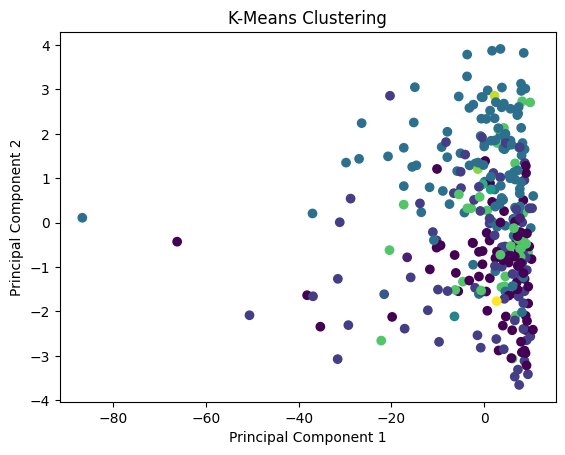

In [17]:
#visual using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(olmstead_encoded)

# Now use kmeans_labels (which holds the cluster assignments) for coloring the scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.show()

In [18]:
#silhoutte score
kmeans_score = silhouette_score(olmstead_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means: {kmeans_score}")

Silhouette Score for K-Means: -0.014523849104669122


In [19]:
#adding a column for cluster into the data
olmstead_encoded['cluster'] = kmeans_labels

In [20]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,walnutash,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar,cluster
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,4
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,4
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,4
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,8
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# **Model 2: Random Forest Regressor**

## Using Random forest regressor to predict invaseness species sum for Cherokee 2024 + 2021 data

In [21]:
# imports for ranfom forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
#creating a column 'invasive_species_sum' based on summing columns 2-16
olmstead_encoded['invasive_species_sum'] = olmstead_encoded.iloc[:, 1:17].sum(axis=1)

In [23]:
olmstead_encoded.head()

,average_canopy_cover,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,...,white,white mulberry,white oak,white pine,willow oak,yellow wood,yellowwood,young tulip poplar,cluster,invasive_species_sum
0,92.98,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,4,20.0
1,98.18,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,4,15.0
2,97.40,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,4,10.0
3,93.24,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,8,17.0
4,87.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,7.0


In [24]:
olmstead_encoded.iloc[:,1:17]

,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,,ailanthus
0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0,0
1,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0,0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0,0
3,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,0,0
4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0,0
307,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,0
308,4.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,2.0,0,0
309,2.0,0.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0,1


In [25]:
#splitting the data
X = olmstead_encoded.drop(['cluster', 'invasive_species_sum'], axis=1)
y = olmstead_encoded['invasive_species_sum']

In [26]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#random forest pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestRegressor(random_state=42))
])

In [28]:
#fitting pipeline
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('rf', RandomForestRegressor(random_state=42))])

In [29]:
#ypred
y_pred = rf_pipeline.predict(X_test)

In [30]:
#evaluating model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 6.003556453297658
R-squared: 0.730992847398469


In [31]:
#evaluating for overfitting
train_score = rf_pipeline.score(X_train, y_train)
test_score = rf_pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.969594134875204
Testing Score: 0.730992847398469


# **Model 3: Apriori Model**

## Version 1: Using Apriori algorithm to find associations between the most common species in the canopy and the understory for Cherokee 2024 data only

In [32]:
# importing for apriori
from mlxtend.frequent_patterns import apriori, association_rules

In [33]:
apriori_data=pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="2024 Cherokee Invasive Survey", skiprows=1)

# renaming columns
apriori_data = apriori_data.rename(columns={'Comment':'Trimble_station', 'Calculated using formula in densiometer.1':'average_canopy_cover', 'Calculated using formula in densiometer':'form_densiometer'})

# Removing the word 'Cherokee' from the Trimble station entries that wya it is left with just its number
apriori_data['Trimble_station'] = apriori_data['Trimble_station'].str.replace('Cherokee', '')

# deleting uneeded columns
apriori_data = apriori_data.drop(['Unnamed: 27', 'N', 'E', 'S', 'W', 'Canopy gap and/or downed trees present', 'Dioscorea polystachya'], axis=1)

# filling in missing values for form_densiomter and average canopy cover with mean
apriori_data['form_densiometer'].fillna(apriori_data['form_densiometer'].mean(), inplace=True)
apriori_data['average_canopy_cover'].fillna(apriori_data['average_canopy_cover'].mean(), inplace=True)

#filling out missing values for all columns with 0
apriori_data.fillna(0, inplace=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
apriori_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,...,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,SUM
0,1,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,20
1,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,15
2,3,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,10
3,4,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,...,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,19
4,5,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7


In [35]:
# Removing the word 'Cherokee' from the Trimble station entries that way it is left with just its number
apriori_data['Trimble_station'] = apriori_data['Trimble_station'].str.replace('Cherokee', '')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
apriori_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,...,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,SUM
0,1,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,20
1,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,15
2,3,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,10
3,4,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,...,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,19
4,5,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7


In [37]:
apriori_data.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Trimble_station', 'form_densiometer', 'average_canopy_cover', 'Canopy',
       'Understory', 'Lonicera japonica', 'Microstegium vimineum',
       'Euonymus alatus', 'Ampelopsis brevipedunculata', 'Morus alba',
       'Celastrus orbiculatus', 'Vinca minor', 'Euonymus fortunei',
       'Akebia quinata', 'Fallopia japonica', 'Achyranthes', 'Hederea helix',
       'L. maackii', 'Privet/ Ligustrum', 'Ailanthus', 'SUM'],
      dtype='object')

In [38]:
#drop all columns except canopy and trimble station
apriori_data = apriori_data.drop(columns=['average_canopy_cover', 'form_densiometer',
       'Lonicera japonica', 'Microstegium vimineum', 'Euonymus alatus',
       'Ampelopsis brevipedunculata', 'Morus alba', 'Celastrus orbiculatus',
       'Vinca minor', 'Euonymus fortunei', 'Akebia quinata',
       'Fallopia japonica', 'Achyranthes', 'Hederea helix', 'L. maackii',
       'Privet/ Ligustrum', 'Ailanthus','SUM'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
apriori_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Canopy,Understory
0,1,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry"
1,2,"Cherry, hackberry, maple","Maple, buckeye, locust"
2,3,"Oak, basswood, maple","Maple, ash"
3,4,"Locust, walnut, sycamore","Ash, hackberry, boxelder"
4,5,"Oak, maple, locust","Ash, hackberry, viburnum"


In [40]:
canopy_apriori_data = apriori_data[['Trimble_station','Canopy']]
canopy_apriori_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Canopy
0,1,"Walnut, maple, mulberry, locust"
1,2,"Cherry, hackberry, maple"
2,3,"Oak, basswood, maple"
3,4,"Locust, walnut, sycamore"
4,5,"Oak, maple, locust"


In [41]:
understory_apriori_data = apriori_data[['Trimble_station','Understory']]
understory_apriori_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Understory
0,1,"Boxelder, maple, hackberry"
1,2,"Maple, buckeye, locust"
2,3,"Maple, ash"
3,4,"Ash, hackberry, boxelder"
4,5,"Ash, hackberry, viburnum"


In [42]:
# clean up function to clean up canopy column
def clean_canopy_as_list_lowercase(entry):
    if pd.isnull(entry):
        return np.nan

    # Standardize entry to lowercase for uniform correction and cleanup
    entry = entry.lower().replace('\xa0', '').replace(',', ', ').replace(',,', ',').strip(', ')

    # Correct common misspellings and ensure uniform formatting
    corrections = {
        'haxkberry': 'hackberry',
        'havkberry': 'hackberry',
        'hackberrt': 'hackberry',
        'maple, ': 'maple',
        'Maple': 'maple',
        'box elderb': 'box elder',
        'elm, hickory': 'elm, hickory',
        'basswood locust red oak ash': 'basswood, locust, red oak, ash',
        'box elder elm hackberryv': 'box elder, elm, hackberry',
    }
    for wrong, correct in corrections.items():
        entry = entry.replace(wrong, correct)

    # Split by commas, remove any extra spaces, and return the cleaned list
    entry_list = [value.strip() for value in entry.split(',')]
    return entry_list

# Apply the new cleaning function with lowercase conversion to the 'canopy' column
canopy_apriori_data['Canopy'] = canopy_apriori_data['Canopy'].apply(clean_canopy_as_list_lowercase)
# Apply the new cleaning function with lowercase conversion to the 'understory' column
understory_apriori_data['Understory'] = understory_apriori_data['Understory'].apply(clean_canopy_as_list_lowercase)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
canopy_apriori_data.sample(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Canopy
62,79,"[beech, red oak, tulip poplar, sycamore]"
71,93,"[hackberry, cherry, sugar maple tulip poplar]"
21,29,"[hickory, locust, hackberry]"
100,125,"[dead ash, walnut, basswood, hickory]"
135,162,"[walnut, ash, maple hackberry, basswood]"
136,163,"[maple hackberry, hickory, walnut]"
72,94,"[yellowwood, walnut, sugar maple cherry]"
29,41,"[tulip poplar, maple hackberry]"
138,165,"[sugar maple white oak, walnut, ash]"
101,126,"[cherry, tulip poplar, hickort]"


In [44]:
understory_apriori_data.sample(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Understory
32,44,"[cherry, hackberry, buckeye, boxelder]"
16,18,[boxelder]
79,101,"[buckeye, ash, maple redbud]"
7,8,"[hackberry, locust, maple ash]"
70,90,"[redbud, maple ash]"
112,137,"[sugar maple beech, cherry]"
47,62,"[boxelder, spicebush, ash, beech, viburnum]"
29,41,"[sycamore, tulip poplar, box elder]"
96,119,"[buckeye, hackberry, pawpaw, ash]"
125,152,"[tulip poplar, maple hackberry, ash]"


In [45]:
# drop the empty canopy rows
canopy_apriori_data = canopy_apriori_data.dropna(subset=['Canopy'])
# drop the empty understory rows
understory_apriori_data = understory_apriori_data.dropna(subset=['Understory'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_canopy_apriori_data = canopy_apriori_data.explode('Canopy')
exploded_canopy_apriori_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Canopy
0,1,walnut
0,1,maple mulberry
0,1,locust
1,2,cherry
1,2,hackberry
1,2,maple
2,3,oak
2,3,basswood
2,3,maple
3,4,locust


In [47]:
# Explode the 'understory' column so each item in the list becomes its own row
exploded_understory_apriori_data = understory_apriori_data.explode('Understory')
exploded_understory_apriori_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Understory
0,1,boxelder
0,1,maple hackberry
1,2,maple buckeye
1,2,locust
2,3,maple ash
3,4,ash
3,4,hackberry
3,4,boxelder
4,5,ash
4,5,hackberry


In [48]:
# One-hot encode using pd.crosstab for canopy
exploded_canopy_apriori_data = pd.crosstab(exploded_canopy_apriori_data['Trimble_station'],exploded_canopy_apriori_data['Canopy'])
exploded_canopy_apriori_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Canopy,,ash,bass wood,basswood,beech,black gum,black locust,box elder,boxelder,carpinus,...,sugar maple tulip poplar,sugar maple white oak,sycamore,tree of heaven,tulip polar,tulip poplar,walnut,white,willow oak,yellowwood
Trimble_station,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
101,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
103,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
104,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
105,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [49]:
# One-hot encode using pd.crosstab for understory
exploded_understory_apriori_data = pd.crosstab(exploded_understory_apriori_data['Trimble_station'],exploded_understory_apriori_data['Understory'])
exploded_understory_apriori_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Understory,acre negundo,aralia,ash,basswood,beech,bladdernut,blue ash,box elder,boxelder,buck thorn,...,sugar maple spicebush,sumac,sycamore,tulip poplar,viburnum,walnut,water leaf,white oak,white snakeroot,wing stem
Trimble_station,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
97,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Apply apriori to find frequent/common species with minimum support 0.04 (species that appeared at least 4% of the time) for canopy
common_canopy_species1 = apriori(exploded_canopy_apriori_data, min_support=0.04, use_colnames=True)
common_canopy_species1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.054422,(ash)
1,0.081633,(basswood)
2,0.136054,(beech)
3,0.061224,(box elder)
4,0.156463,(cherry)
5,0.074830,(elm)
6,0.265306,(hackberry)
7,0.136054,(hickory)
8,0.061224,(locust)
9,0.108844,(maple)


In [51]:
# Apply apriori to find frequent/common species with minimum support 0.04 (species that appeared at least 4% of the time) for understory
common_understory_species1 = apriori(exploded_understory_apriori_data, min_support=0.04, use_colnames=True)
common_understory_species1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.333333,(ash)
1,0.095238,(box elder)
2,0.183673,(boxelder)
3,0.088435,(buckeye)
4,0.068027,(cherry)
5,0.040816,(elm)
6,0.278912,(hackberry)
7,0.122449,(hickory)
8,0.054422,(holly)
9,0.108844,(maple)


Comparing top assocations for canopy and understory

In [52]:
# generate association rule from the common species with minimum confidence 0.04 (4% confidence) using num_itemsets for canopy
apriori_canopy_rules = association_rules(common_canopy_species1, metric='confidence',  num_itemsets=len(common_canopy_species1), min_threshold=0.04)
print(apriori_canopy_rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


       antecedents     consequents   support  confidence      lift
0       (basswood)        (walnut)  0.040816    0.500000  2.041667
1         (walnut)      (basswood)  0.040816    0.166667  2.041667
2         (cherry)         (maple)  0.040816    0.260870  2.396739
3          (maple)        (cherry)  0.040816    0.375000  2.396739
4         (cherry)  (tulip poplar)  0.074830    0.478261  2.197011
5   (tulip poplar)        (cherry)  0.074830    0.343750  2.197011
6      (hackberry)        (locust)  0.047619    0.179487  2.931624
7         (locust)     (hackberry)  0.047619    0.777778  2.931624
8      (hackberry)        (walnut)  0.068027    0.256410  1.047009
9         (walnut)     (hackberry)  0.068027    0.277778  1.047009
10       (hickory)        (walnut)  0.040816    0.300000  1.225000
11        (walnut)       (hickory)  0.040816    0.166667  1.225000
12         (maple)  (tulip poplar)  0.040816    0.375000  1.722656
13  (tulip poplar)         (maple)  0.040816    0.187500  1.72

In [53]:
# generate association rule from the common species with minimum confidence 0.04 (4% confidence) using num_itemsets for understory
apriori_understory_rules = association_rules(common_understory_species1, metric='confidence',  num_itemsets=len(common_understory_species1), min_threshold=0.04)
print(apriori_understory_rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    antecedents  consequents   support  confidence      lift
0         (ash)   (boxelder)  0.047619    0.142857  0.777778
1    (boxelder)        (ash)  0.047619    0.259259  0.777778
2         (ash)    (buckeye)  0.040816    0.122449  1.384615
3     (buckeye)        (ash)  0.040816    0.461538  1.384615
4         (ash)  (hackberry)  0.108844    0.326531  1.170732
5   (hackberry)        (ash)  0.108844    0.390244  1.170732
6     (hickory)        (ash)  0.040816    0.333333  1.000000
7         (ash)    (hickory)  0.040816    0.122449  1.000000
8         (ash)     (pawpaw)  0.047619    0.142857  0.840000
9      (pawpaw)        (ash)  0.047619    0.280000  0.840000
10     (redbud)        (ash)  0.047619    0.333333  1.000000
11        (ash)     (redbud)  0.047619    0.142857  1.000000
12  (hackberry)   (boxelder)  0.047619    0.170732  0.929539
13   (boxelder)  (hackberry)  0.047619    0.259259  0.929539
14    (hickory)  (hackberry)  0.054422    0.444444  1.593496
15  (hackberry)    (hick

For Canopy Column in 2024 Data:
* Based on the Apriori model, we are 5% confident that basswood and wlanut appear together frequently within the canopy.
* We are 4.8% confident that cherry and tulip poplar appear together frequently within the canopy.
* We are 3.7% confident that cherry and maple appear together frequently within the canopy.
* These assocations listed above have strong assocations since their lifts are at least 2.

For Understory Column in 2024 Data:
* Based on the Apriori model, we are 4.6% confident that buckeye and ash appear together frequently within the understory.
* We are 4.44% confident that hickory and hackberry appear together frequently within the understory.
* We are 3.75% confident that maple and hackberry appear together frequently within the understory.
* These associations listed above have strong associations since their lists have a value of 1.

Note: the reasoning for such a low confidence has to do with how small the dataset was.

## Using Apriori algorithm to find associations between the most common species in the canopy and the understory for Cherokee 2021 data only


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Version 2: Using Apriori algorithm to find associations between the most common species in the canopy and the understory for Cherokee 2024 data only

In [54]:
# loading dataset
# using skiprows=1 to skip the first row of the dataset
model_data=pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="2024 Cherokee Invasive Survey", skiprows=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# renaming columns
model_data = model_data.rename(columns={'Comment':'Trimble_station', 'Calculated using formula in densiometer.1':'average_canopy_cover', 'Calculated using formula in densiometer':'form_densiometer'})

# Removing the word 'Cherokee' from the Trimble station entries that wya it is left with just its number
model_data['Trimble_station'] = model_data['Trimble_station'].str.replace('Cherokee', '')

# checking if the entries were changed
model_data.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,N,E,S,W,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,...,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,Canopy gap and/or downed trees present,SUM,Dioscorea polystachya,Unnamed: 27
0,1,12.0,3,5,7,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,...,0.0,1.0,3.0,3.0,0.0,0.0,2.0,20,NaN,NaN
1,2,3.0,0,2,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,15,NaN,NaN
2,3,1.0,0,4,5,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,...,0.0,0.0,1.0,3.0,0.0,0.0,1.0,10,NaN,NaN
3,4,13.0,3,4,6,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,...,0.0,4.0,2.0,1.0,0.0,2.0,1.0,19,NaN,1.0
4,5,15.0,12,3,20,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7,NaN,NaN


In [56]:
# deleting uneeded columns
model_data = model_data.drop(['Unnamed: 27', 'N', 'E', 'S', 'W', 'Canopy gap and/or downed trees present', 'Dioscorea polystachya'], axis=1)

# filling in missing values for form_densiomter and average canopy cover with mean
model_data['form_densiometer'].fillna(model_data['form_densiometer'].mean(), inplace=True)
model_data['average_canopy_cover'].fillna(model_data['average_canopy_cover'].mean(), inplace=True)

#filling out missing values for all columns with 0
model_data.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# Ensure "Canopy" column entries are strings, replacing NaNs with empty strings
model_data['Canopy'] = model_data['Canopy'].fillna('').astype(str)

# Split species in the canopy column
model_data['Canopy'] = model_data['Canopy'].str.split(', ')

# Ensure "Understory" column entries are strings, replacing NaNs with empty strings
model_data['Understory'] = model_data['Understory'].fillna('').astype(str)

# Split species in the understory column
model_data['Understory'] = model_data['Understory'].str.split(', ')

# Display the processed DataFrame with binary columns
model_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,...,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,SUM
0,1,7.02,92.98,"[Walnut, maple, mulberry, locust]","[Boxelder, maple, hackberry]",1.0,2.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,20
1,2,1.82,98.18,"[Cherry, hackberry, maple]","[Maple, buckeye, locust ]",4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,15
2,3,2.60,97.40,"[Oak, basswood, maple]","[Maple, ash]",3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,10
3,4,6.76,93.24,"[Locust, walnut, sycamore]","[Ash, hackberry, boxelder]",1.0,1.0,0.0,4.0,0.0,...,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,19
4,5,13.00,87.00,"[Oak, maple, locust ]","[Ash, hackberry, viburnum]",0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7
5,6,1.82,98.18,"[Sycamore, hackberry, cottonwood ]","[Dogwood, hickory, boxelder]",3.0,0.0,0.0,2.0,2.0,...,0.0,3.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,16
6,7,7.28,92.72,"[Sycamore, tulip poplar]","[Dogwood, elm, ash]",0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
7,8,7.54,92.46,"[Locust, hackberry]","[Hackberry, locust, maple, ash]",1.0,2.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,4.0,3.0,4.0,0.0,0.0,21
8,9,7.02,92.98,"[Locust, pine, hackberry]","[Devils walking stick, hackberry]",4.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,17
9,10,1.04,98.96,"[Sycamore, walnut, elm ]","[Boxelder, hackberry]",1.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,10


In [58]:
model_data.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Trimble_station', 'form_densiometer', 'average_canopy_cover', 'Canopy',
       'Understory', 'Lonicera japonica', 'Microstegium vimineum',
       'Euonymus alatus', 'Ampelopsis brevipedunculata', 'Morus alba',
       'Celastrus orbiculatus', 'Vinca minor', 'Euonymus fortunei',
       'Akebia quinata', 'Fallopia japonica', 'Achyranthes', 'Hederea helix',
       'L. maackii', 'Privet/ Ligustrum', 'Ailanthus', 'SUM'],
      dtype='object')

In [59]:
# drop all columns except canopy, understory, and trimble station
model_data = model_data.drop(columns=['form_densiometer','average_canopy_cover',
       'Lonicera japonica', 'Microstegium vimineum',
       'Euonymus alatus', 'Ampelopsis brevipedunculata', 'Morus alba',
       'Celastrus orbiculatus', 'Vinca minor', 'Euonymus fortunei',
       'Akebia quinata', 'Fallopia japonica', 'Achyranthes', 'Hederea helix',
       'L. maackii', 'Privet/ Ligustrum', 'Ailanthus', 'SUM'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
model_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Canopy,Understory
0,1,"[Walnut, maple, mulberry, locust]","[Boxelder, maple, hackberry]"
1,2,"[Cherry, hackberry, maple]","[Maple, buckeye, locust ]"
2,3,"[Oak, basswood, maple]","[Maple, ash]"
3,4,"[Locust, walnut, sycamore]","[Ash, hackberry, boxelder]"
4,5,"[Oak, maple, locust ]","[Ash, hackberry, viburnum]"
5,6,"[Sycamore, hackberry, cottonwood ]","[Dogwood, hickory, boxelder]"
6,7,"[Sycamore, tulip poplar]","[Dogwood, elm, ash]"
7,8,"[Locust, hackberry]","[Hackberry, locust, maple, ash]"
8,9,"[Locust, pine, hackberry]","[Devils walking stick, hackberry]"
9,10,"[Sycamore, walnut, elm ]","[Boxelder, hackberry]"


In [61]:
# Explode the 'canopy' column so each item in the list becomes its own row
exploded_canopy_model_data = model_data[['Trimble_station','Canopy']].explode('Canopy')
exploded_canopy_model_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Canopy
0,1,Walnut
0,1,maple
0,1,mulberry
0,1,locust
1,2,Cherry
1,2,hackberry
1,2,maple
2,3,Oak
2,3,basswood
2,3,maple


In [62]:
# Explode the 'Understory' column so each item in the list becomes its own row
exploded_understory_model_data = model_data[['Trimble_station','Understory']].explode('Understory')
exploded_understory_model_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,Understory
0,1,Boxelder
0,1,maple
0,1,hackberry
1,2,Maple
1,2,buckeye
1,2,locust
2,3,Maple
2,3,ash
3,4,Ash
3,4,hackberry


In [63]:
# One-hot encode using pd.crosstab for canopy data
exploded_canopy_model_data = pd.crosstab(exploded_canopy_model_data['Trimble_station'],exploded_canopy_model_data['Canopy'])
exploded_canopy_model_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Canopy,,,Basswood,Beech,Box elder,Boxelder,"Carpinus,",Cherry,Chestnut oaks,Dead ash,...,serviceberry,sugar maple,sycamore,sycamore,tulip poplar,tulip poplar,walnut,walnut,white,white oak
Trimble_station,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
101,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
103,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
104,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


In [64]:
# Apply apriori to find frequent/common species with minimum support 0.04 (species that appeared at least 4% of the time) within canopy
common_canopy_species = apriori(exploded_canopy_model_data, min_support=0.04, use_colnames=True)
common_canopy_species

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.095238,()
1,0.068027,(Beech)
2,0.061224,(Cherry)
3,0.088435,(Hackberry)
4,0.047619,(Hickory)
5,0.149660,(Maple)
6,0.088435,(Oak)
7,0.074830,(Sycamore)
8,0.102041,(Tulip poplar)
9,0.095238,(Walnut)


In [65]:
# generate association rule from the common species with minimum confidence 0.04 (4% confidence) using num_itemsets within canopy
canopy_rules = association_rules(common_canopy_species, metric='confidence',  num_itemsets=len(common_canopy_species), min_threshold=0.04)
print(canopy_rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


       antecedents     consequents   support  confidence      lift
0               ()        (walnut)  0.040816    0.428571  2.333333
1         (walnut)              ()  0.040816    0.222222  2.333333
2          (maple)         (Beech)  0.040816    0.150000  2.205000
3          (Beech)         (maple)  0.040816    0.600000  2.205000
4      (hackberry)         (Maple)  0.054422    0.266667  1.781818
5          (Maple)     (hackberry)  0.054422    0.363636  1.781818
6   (tulip poplar)         (Maple)  0.054422    0.275862  1.843260
7          (Maple)  (tulip poplar)  0.054422    0.363636  1.843260
8          (maple)  (Tulip poplar)  0.047619    0.175000  1.715000
9   (Tulip poplar)         (maple)  0.047619    0.466667  1.715000
10         (maple)      (basswood)  0.040816    0.150000  1.696154
11      (basswood)         (maple)  0.040816    0.461538  1.696154
12         (maple)     (hackberry)  0.061224    0.225000  1.102500
13     (hackberry)         (maple)  0.061224    0.300000  1.10

In [66]:
# One-hot encode using pd.crosstab for understory data
exploded_understory_model_data = pd.crosstab(exploded_understory_model_data['Trimble_station'],exploded_understory_model_data['Understory'])
exploded_understory_model_data.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Understory,,,Ash,Basswood,Bladdernut,Blue ash,Box elder,Boxelder,Boxelder,"Boxelder,ash",...,sumac,sycamore,tulip poplar,viburnum,walnut,water leaf,white oak,white snakeroot,white snakeroot,wing stem
Trimble_station,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# Apply apriori to find frequent/common species with minimum support 0.04 (species that appeared at least 4% of the time) within understory
common_understory_species = apriori(exploded_understory_model_data, min_support=0.04, use_colnames=True)
common_understory_species

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.081633,()
1,0.081633,(Ash)
2,0.040816,(Box elder)
3,0.102041,(Boxelder)
4,0.074830,(Hackberry)
5,0.197279,(Maple)
6,0.061224,(Pawpaw)
7,0.074830,(Redbud)
8,0.061224,(Spicebush)
9,0.040816,(Sugar maple)


In [68]:
# generate association rule from the common species with minimum confidence 0.04 (4% confidence) using num_itemsets within understory
understory_rules = association_rules(common_understory_species, metric='confidence',  num_itemsets=len(common_understory_species), min_threshold=0.04)
print(understory_rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']])

    antecedents  consequents   support  confidence      lift
0       (maple)   (Boxelder)  0.040816    0.139535  1.367442
1    (Boxelder)      (maple)  0.040816    0.400000  1.367442
2       (maple)  (Hackberry)  0.040816    0.139535  1.864693
3   (Hackberry)      (maple)  0.040816    0.545455  1.864693
4         (ash)      (Maple)  0.054422    0.186047  0.943063
5       (Maple)        (ash)  0.054422    0.275862  0.943063
6   (hackberry)      (Maple)  0.040816    0.162162  0.821994
7       (Maple)  (hackberry)  0.040816    0.206897  0.821994
8         (ash)  (hackberry)  0.068027    0.232558  0.923947
9   (hackberry)        (ash)  0.068027    0.270270  0.923947
10    (hickory)        (ash)  0.047619    0.350000  1.196512
11        (ash)    (hickory)  0.047619    0.162791  1.196512
12      (maple)        (ash)  0.088435    0.302326  1.033532
13        (ash)      (maple)  0.088435    0.302326  1.033532
14    (hickory)  (hackberry)  0.040816    0.300000  1.191892
15  (hackberry)    (hick

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Comparing top assocations for canopy and understory

In [69]:
print(canopy_rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']].head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   antecedents consequents   support  confidence      lift
0           ()    (walnut)  0.040816    0.428571  2.333333
1     (walnut)          ()  0.040816    0.222222  2.333333
2      (maple)     (Beech)  0.040816    0.150000  2.205000
3      (Beech)     (maple)  0.040816    0.600000  2.205000
4  (hackberry)     (Maple)  0.054422    0.266667  1.781818


In [70]:
print(understory_rules[['antecedents', 'consequents', 'support',	'confidence', 'lift']].head())

   antecedents  consequents   support  confidence      lift
0      (maple)   (Boxelder)  0.040816    0.139535  1.367442
1   (Boxelder)      (maple)  0.040816    0.400000  1.367442
2      (maple)  (Hackberry)  0.040816    0.139535  1.864693
3  (Hackberry)      (maple)  0.040816    0.545455  1.864693
4        (ash)      (Maple)  0.054422    0.186047  0.943063


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For Canopy Column in 2024 Data:
* Based on the Apriori model, we are 6% confident that beech and maple appear together frequently within the canopy.
* We are 4.7% confident that tulip poplar and maple appear together frequently within the canopy.
* We are 4.3% confident that walnut does not appear with any other species within the canopy.

For Understory COlumn in 2024 Data:
* Based on the Apriori model, we are 4% confident that maple and boxelder appear together frequently within the understory.
* We are 5.5% confident that mape and hackberry appear together frequently within the understory.
* We are 2.7% confident that maple and ash appear together frequently within the understory.

Note: the reasoning for such a low confidence has to do with how small the dataset was.

# **Model 4: Random Forest Regression Model**

## Predicting the average canopy cover using a random forest regression on the cherokee park 2024 data

In [241]:
# imports for random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [242]:
# loading dataset
# using skiprows=1 to skip the first row of the dataset
class_data=pd.read_excel("/content/drive/MyDrive/CS 430 Group Project/olmstead_dataset.xlsx", sheet_name="2024 Cherokee Invasive Survey", skiprows=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [243]:
# renaming columns
class_data = class_data.rename(columns={'Comment':'Trimble_station', 'Calculated using formula in densiometer.1':'average_canopy_cover', 'Calculated using formula in densiometer':'form_densiometer'})

# Removing the word 'Cherokee' from the Trimble station entries that wya it is left with just its number
class_data['Trimble_station'] = class_data['Trimble_station'].str.replace('Cherokee', '')

# checking if cherokee was removed
class_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,N,E,S,W,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,...,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,Canopy gap and/or downed trees present,SUM,Dioscorea polystachya,Unnamed: 27
0,1,12.0,3,5,7,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,...,0.0,1.0,3.0,3.0,0.0,0.0,2.0,20,NaN,NaN
1,2,3.0,0,2,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,15,NaN,NaN
2,3,1.0,0,4,5,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,...,0.0,0.0,1.0,3.0,0.0,0.0,1.0,10,NaN,NaN
3,4,13.0,3,4,6,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,...,0.0,4.0,2.0,1.0,0.0,2.0,1.0,19,NaN,1.0
4,5,15.0,12,3,20,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7,NaN,NaN


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

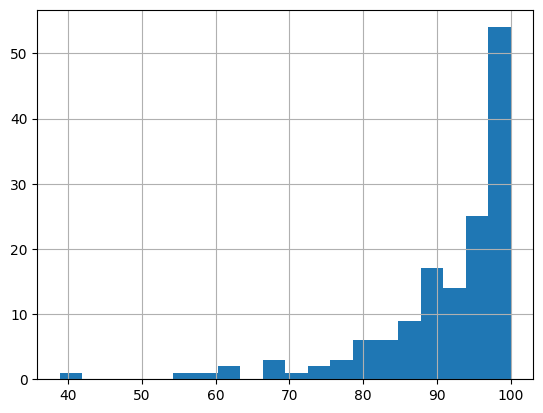

In [244]:
# graphing the distribution of average canopy cover
class_data['average_canopy_cover'].hist(bins=20)

In [245]:
# checking how amny nul values average canopy cover has
class_data['average_canopy_cover'].isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2

In [246]:
# deleting uneeded columns
class_data = class_data.drop(['Unnamed: 27', 'N', 'E', 'S', 'W', 'Canopy gap and/or downed trees present', 'Dioscorea polystachya','SUM'], axis=1)

# filling in missing values for form_densiomter and average canopy cover with median
#class_data['form_densiometer'].fillna(class_data['form_densiometer'].median(), inplace=True)
#class_data['average_canopy_cover'].fillna(class_data['average_canopy_cover'].median(), inplace=True)

# filling missing values for the rest of the columns with 0
class_data.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [247]:
#creating a column 'invasive_species_sum' based on summing columns
class_data['invasive_species_sum'] = class_data.iloc[:, 5:20].sum(axis=1)
class_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,...,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,invasive_species_sum
0,1,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,20.0
1,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,15.0
2,3,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,10.0
3,4,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,...,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,19.0
4,5,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0


In [248]:
# splitting the data into features and target variable
X = class_data.drop(['invasive_species_sum', 'average_canopy_cover', 'Canopy', 'Understory', 'Trimble_station'], axis=1)
y = class_data['average_canopy_cover']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [249]:
y.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
average_canopy_cover,
97.40,8
98.18,8
98.44,7
97.66,6
97.92,6
...,...
73.74,1
60.74,1
38.90,1


In [250]:
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,form_densiometer,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,Celastrus orbiculatus,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus
0,7.02,1.0,2.0,0.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0
1,1.82,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0
2,2.60,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0
3,6.76,1.0,1.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0
4,13.00,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,9.36,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
143,30.94,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
144,24.44,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
145,36.92,3.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0


In [251]:
# split the data into test set and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [252]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 135 to 102
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   form_densiometer             117 non-null    float64
 1   Lonicera japonica            117 non-null    float64
 2   Microstegium vimineum        117 non-null    float64
 3   Euonymus alatus              117 non-null    float64
 4   Ampelopsis brevipedunculata  117 non-null    float64
 5   Morus alba                   117 non-null    float64
 6   Celastrus orbiculatus        117 non-null    float64
 7   Vinca minor                  117 non-null    float64
 8   Euonymus fortunei            117 non-null    float64
 9   Akebia quinata               117 non-null    float64
 10  Fallopia japonica            117 non-null    float64
 11  Achyranthes                  117 non-null    float64
 12  Hederea helix                117 non-null    float64
 13  L. maackii             

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [253]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 125 to 11
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   form_densiometer             30 non-null     float64
 1   Lonicera japonica            30 non-null     float64
 2   Microstegium vimineum        30 non-null     float64
 3   Euonymus alatus              30 non-null     float64
 4   Ampelopsis brevipedunculata  30 non-null     float64
 5   Morus alba                   30 non-null     float64
 6   Celastrus orbiculatus        30 non-null     float64
 7   Vinca minor                  30 non-null     float64
 8   Euonymus fortunei            30 non-null     float64
 9   Akebia quinata               30 non-null     float64
 10  Fallopia japonica            30 non-null     float64
 11  Achyranthes                  30 non-null     float64
 12  Hederea helix                30 non-null     float64
 13  L. maackii               

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [254]:
# extracting the numerical features
numerical_features = X.select_dtypes(include=['number'])

# extracting catergoircal features
categorical_features = X.select_dtypes(include=['object'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [255]:
# setting up a column transformer to use standard scaling for numerical columns and one hot encoding for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features.columns),
        ('cat', OneHotEncoder(), categorical_features.columns)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [256]:
# running the pipeline to fit the random forest classifier model
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['form_densiometer', 'Lonicera japonica', 'Microstegium vimineum',
       'Euonymus alatus', 'Ampelopsis brevipedunculata', 'Morus alba',
       'Celastrus orbiculatus', 'Vinca minor', 'Euonymus fortunei',
       'Akebia quinata', 'Fallopia japonica', 'Achyranthes', 'Hederea helix',
       'L. maackii', 'Privet/ Ligustrum', 'Ailanthus'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index([], dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [257]:
# evaluating model

# creating y_pred
y_pred = pipeline.predict(X_test)

# looking at mean squared error for test
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Test): {mse}")
# looking at root mean squared error for test
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (Test): {rmse}")

# looking at mean squared error for train
train_mse = mean_squared_error(y_train, pipeline.predict(X_train))
print(f"Mean Squared Error (Training): {train_mse}")
# looking at root mean squared error for train
train_rmse = np.sqrt(train_mse)
print(f"Root Mean Squared Error (Training): {train_rmse}")

# loking at the r-sqaured value
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

Mean Squared Error (Test): 173.31542762266648
Root Mean Squared Error (Test): 13.164931736346622
Mean Squared Error (Training): 17.1629917880342
Root Mean Squared Error (Training): 4.142824131921871
R-squared: 0.5772559567512886


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [258]:
# checking for overfitting
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Training Score: 0.8924931724451892
Testing Score: 0.5772559567512886


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INTERPRET

# **Model 5: Random Forest Classification Model**

## Using a random forest classification model to classify the invasiveness sum for the 2024 data

In [259]:
# imports for random forest classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [260]:
class_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trimble_station,form_densiometer,average_canopy_cover,Canopy,Understory,Lonicera japonica,Microstegium vimineum,Euonymus alatus,Ampelopsis brevipedunculata,Morus alba,...,Vinca minor,Euonymus fortunei,Akebia quinata,Fallopia japonica,Achyranthes,Hederea helix,L. maackii,Privet/ Ligustrum,Ailanthus,invasive_species_sum
0,1,7.02,92.98,"Walnut, maple, mulberry, locust","Boxelder, maple, hackberry",1.0,2.0,0.0,3.0,0.0,...,0.0,3.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,20.0
1,2,1.82,98.18,"Cherry, hackberry, maple","Maple, buckeye, locust",4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,15.0
2,3,2.60,97.40,"Oak, basswood, maple","Maple, ash",3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,10.0
3,4,6.76,93.24,"Locust, walnut, sycamore","Ash, hackberry, boxelder",1.0,1.0,0.0,4.0,0.0,...,0.0,4.0,0.0,0.0,4.0,2.0,1.0,0.0,2.0,19.0
4,5,13.00,87.00,"Oak, maple, locust","Ash, hackberry, viburnum",0.0,0.0,0.0,2.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0


In [261]:
# looking at the value counts for the invaseness sum
class_data['invasive_species_sum'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
invasive_species_sum,
10.0,16
15.0,13
8.0,12
12.0,12
11.0,11
4.0,10
7.0,10
5.0,8
14.0,7


In [262]:
# encoding the invaseness sum column into 5 groups

# for the invasiness sum between 0 to 4, classify as 'very low'
class_data.loc[class_data['invasive_species_sum'] <= 4, 'invasive_species_sum'] = 'very low'

# for the invasiness sum between 5 to 8, classify as 'low'
class_data.loc[(class_data['invasive_species_sum'] >= 5) & (class_data['invasive_species_sum'] <= 8), 'invasive_species_sum'] = 'low'

# for the invasiness sum between 9 to 12, classify as 'medium'
class_data.loc[(class_data['invasive_species_sum'] >= 9) & (class_data['invasive_species_sum'] <= 12), 'invasive_species_sum'] = 'medium'

# for the invasiness sum between 13 to 16, classify as 'high'
class_data.loc[(class_data['invasive_species_sum'] >= 13) & (class_data['invasive_species_sum'] <= 16), 'invasive_species_sum'] = 'high'

# for the invasiness sum 17 and greater, classify as 'very high'
class_data.loc[class_data['invasive_species_sum'] >= 17, 'invasive_species_sum'] = 'very high'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: '>=' not supported between instances of 'str' and 'int'

In [93]:
# import random forest
#from sklearn.ensemble import RandomForestClassifier
#classifier=RandomForestClassifier(n_estimators=100)
#classifier.fit(X_train.values, y_train)
#y_pred=classifier.predict(X_test.values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
# setting up a column transformer to use standard scaling for numerical columns and one hot encoding for categorical columns
#preprocessor = ColumnTransformer(
    #transformers=[
        #('num', StandardScaler(), numerical_features.columns),
        #('cat', OneHotEncoder(), categorical_features.columns)
    #])

#pipeline = Pipeline([
    #('preprocessor', preprocessor),
    #('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
#])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
# looking at accuracy score
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy}")

#print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
